# Evaluate trained model and fine-tune inference
__Note:__ For this tutorial to work, you first need to download some data and example models (266MB) from [here](https://www.dropbox.com/sh/wnj3389k8ei8i1c/AACy7apWxW87IS_fBjI8-7WDa?dl=0) and put the four folders in the `tutorials` folder.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import dss.utils, dss.utils_plot, dss.predict, dss.event_utils, dss.evaluate

`save_name` should be the stem common to all files produced during training.
For instance, if the parameter file for the model is `res/20191121_094529_params.yaml`, then `save_name` should be `res/20191121_094529`.

In [2]:
save_name = 'models/dmel_sine_tcn_single_channel/'  # best TCN model for single-channel dmel sine song
params = dss.utils.load_params(save_name)

# TODO: is this real
print(params)
dwn_smp = 1
if 'cnn' in params['model_name']:
#     params['y_offset'] = int(round(params['nb_hist']/2))
    y_offset = params['y_offset']
else:
    y_offset = params['data_padding']

fs = params['samplerate_y_Hz']


try: 
    segment_pred_index = params['class_types'][1:].index('segment') + 1
    print(f'model predicts segments at index {segment_pred_index}')
except ValueError:
    print('model does not predict segments.')
    segment_pred_index = None

   
try: 
    pulse_pred_index = params['class_types'].index('event')    
    print(f'model predicts pulses at index {pulse_pred_index}')

except ValueError:
    print('model does not predict pulse.')
    pulse_pred_index = None

print(fs, y_offset)

{'batch_norm': True, 'batch_size': 32, 'class_names': ['noise', 'sine'], 'class_names_pulse': ['noise', 'pulse'], 'class_names_sine': ['noise', 'sine'], 'class_types': ['segment', 'segment'], 'class_types_pulse': ['segment', 'event'], 'class_types_sine': ['segment', 'segment'], 'cut_trailing_dim': True, 'data_dir': '../dat/dmel_single_stern_raw.npy', 'data_padding': 24, 'dwnsmp': 1, 'eventtimes_units_Hz': 'seconds', 'fraction_data': 1.0, 'ignore_boundaries': True, 'keep_intermediates': False, 'kernel_size': 48, 'loss': 'categorical_crossentropy', 'model_name': 'tcn', 'nb_channels': 1, 'nb_classes': 2, 'nb_conv': 4, 'nb_filters': 32, 'nb_freq': 1, 'nb_hist': 4096, 'nb_stacks': 2, 'return_sequences': True, 'sample_weight_mode': 'temporal', 'samplerate_x_Hz': 10000, 'samplerate_y_Hz': 10000, 'save_dir': 'res.stern_raw/res.sine', 'stride': 4048, 'with_y_hist': True, 'y_offset': 0, 'y_suffix': 'sine'}
model predicts segments at index 1
model does not predict pulse.
10000 24


In [3]:
datasets = dss.utils.load_from(save_name + '_results.h5', ['x_test', 'y_test', 'y_pred'])
x_test, y_test, y_pred = [datasets[key] for key in ['x_test', 'y_test', 'y_pred']]  # unpack dict items to vars

labels_test = dss.predict.labels_from_probabilities(y_test)
labels_pred = dss.predict.labels_from_probabilities(y_pred)

The threshold that maximizes the F1 score is chosen as a default (and is typically 0.5). But this part introduces some flexibility, allowing you to fine tune inference between precision (reduce false positives) and recall (maximize event detection)

(193568,) (193569,)
Best f1 score of 0.91) at a threshold at0.38.


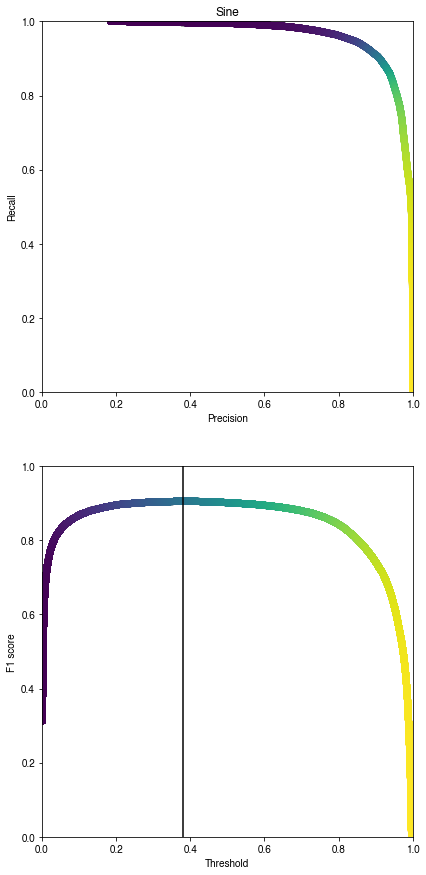

In [4]:
# class-wise precision-recall curves
plt.gcf().set_size_inches(20, 15)
cls_label = params['class_names']
for cls in range(1, len(cls_label)):
    precision, recall, threshold = sklearn.metrics.precision_recall_curve(y_test[::10,cls]>0.5, y_pred[::10, cls])    
    f1score = 2 * (precision * recall) / (precision + recall)
    
    threshold_opt = threshold[np.argmax(f1score)]
    
    plt.subplot(2,2,cls)
    plt.scatter(precision[:-1:10], recall[:-1:10], c=threshold[::10])
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title(cls_label[cls].capitalize())
    plt.axis('square')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    plt.subplot(2,2,2+cls)
    print(threshold.shape, f1score.shape)
    plt.scatter(threshold[:], f1score[:-1], c=threshold[:])
    plt.axvline(threshold_opt, c='k')
    plt.xlabel('Threshold')
    plt.ylabel('F1 score')
    plt.axis('square')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    print(f'Best f1 score of {np.max(f1score):1.2f}) at a threshold at{threshold_opt:1.2f}.')


In [7]:
labels_pred = dss.predict.labels_from_probabilities(y_pred[:, 1], threshold=threshold_opt)
conf_mat, report = dss.evaluate.evaluate_segments(labels_test, labels_pred, params['class_names'])
print('Performance with treshold that maximizes the f1 score (geometric mean of precision and recall):')
print(report)

# to bias towards precision (reduce false positives), you can chose a slightly higher threshold
labels_pred = dss.predict.labels_from_probabilities(y_pred[:, 1], threshold=0.5)  
conf_mat, report = dss.evaluate.evaluate_segments(labels_test, labels_pred, params['class_names'])
print('Performance with slightly higher treshold:')
print(report)


Performance with treshold that maximizes the f1 score (geometric mean of precision and recall):
              precision    recall  f1-score   support

       noise       0.99      0.99      0.99   3522990
        sine       0.91      0.90      0.91    363090

    accuracy                           0.98   3886080
   macro avg       0.95      0.95      0.95   3886080
weighted avg       0.98      0.98      0.98   3886080

Performance with slightly higher treshold:
              precision    recall  f1-score   support

       noise       0.99      0.99      0.99   3522990
        sine       0.93      0.88      0.90    363090

    accuracy                           0.98   3886080
   macro avg       0.96      0.93      0.95   3886080
weighted avg       0.98      0.98      0.98   3886080



In [8]:
# fine tune segment prediction - min_len and gap_fill
# maybe alternatively eval timing of onsets and offsets?
def fill_gaps(sine_pred, gap_dur=100):
    onsets = np.where(np.diff(sine_pred.astype(np.int))==1)[0]
    offsets = np.where(np.diff(sine_pred.astype(np.int))==-1)[0]
    if len(onsets) and len(offsets):
        onsets = onsets[onsets<offsets[-1]]
        offsets = offsets[offsets>onsets[0]]
        durations = offsets - onsets
        for idx, (onset, offset, duration) in enumerate(zip(onsets, offsets, durations)):
            if idx>0 and offsets[idx-1]>onsets[idx]-gap_dur:
                sine_pred[offsets[idx-1]:onsets[idx]+1] = 1
    return sine_pred

def remove_short(sine_pred, min_len=100):
    # remove too short sine songs
    onsets = np.where(np.diff(sine_pred.astype(np.int))==1)[0]
    offsets = np.where(np.diff(sine_pred.astype(np.int))==-1)[0]
    if len(onsets) and len(offsets):
        onsets = onsets[onsets<offsets[-1]]
        offsets = offsets[offsets>onsets[0]]
        durations = offsets - onsets
        for cnt, (onset, offset, duration) in enumerate(zip(onsets, offsets, durations)):
            if duration<min_len:
                sine_pred[onset:offset+1] = 0
    return sine_pred


labels_pred1 = labels_pred.copy()

gap_dur = 40 / 1000 * fs  # fill all gaps between segments smaller than 40ms
labels_pred2 = fill_gaps(labels_pred1.copy(), gap_dur)

min_len = 25 / 1000 * fs  # delete all remaining segments shorter than 25ms
labels_pred3 = remove_short(labels_pred2.copy(), min_len)

conf_mat, report = dss.evaluate.evaluate_segments(labels_test, labels_pred2, params['class_names'])
print('Performance after filling gaps:')
print(report)

conf_mat, report = dss.evaluate.evaluate_segments(labels_test, labels_pred3, params['class_names'])
print('Performance after filling gaps and deleting short segments:')
print(report)


Performance after filling gaps:
              precision    recall  f1-score   support

       noise       0.99      0.99      0.99   3522990
        sine       0.91      0.90      0.90    363090

    accuracy                           0.98   3886080
   macro avg       0.95      0.94      0.95   3886080
weighted avg       0.98      0.98      0.98   3886080

Performance after filling gaps and deleting short segments:
              precision    recall  f1-score   support

       noise       0.99      0.99      0.99   3522990
        sine       0.91      0.90      0.90    363090

    accuracy                           0.98   3886080
   macro avg       0.95      0.94      0.95   3886080
weighted avg       0.98      0.98      0.98   3886080



## Evaluate segment onset and offset timing
This is not so relevant for Drosophila sine song, for which on and offset are often hard to define precisely due to low SNR, but crucial for delineating syllabled for bird song or rodent USVs.

10000
{'FP': 27, 'TP': 66, 'FN': 33, 'precision': 0.7096774193548387, 'recall': 0.6666666666666666, 'f1_score': 0.6875}
{'FP': 20, 'TP': 73, 'FN': 26, 'precision': 0.7849462365591398, 'recall': 0.7373737373737373, 'f1_score': 0.7604166666666667}
Temporal errors of all predicted sine onsets: 18.40 ms
Temporal errors of all predicted sine offsets: 14.60 ms


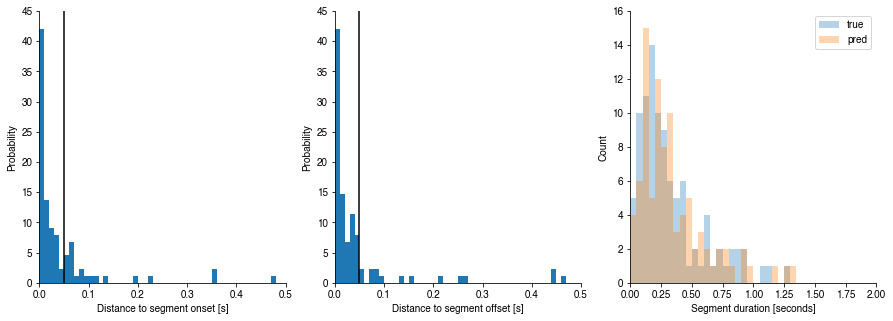

In [18]:
def fixlen(onsets, offsets):
    if len(onsets) > len(offsets):
        onsets = onsets[:-1]
    elif len(offsets) > len(onsets):
        offsets = offsets[1:]
    return onsets, offsets

        
    
tol = .05  # seconds = 50ms
print(fs)
if segment_pred_index is not None:
    segment_onset_times_true, segment_offset_times_true = fixlen(*dss.evaluate.segment_timing(labels_test, fs))
    segment_onset_times_pred, segment_offset_times_pred = fixlen(*dss.evaluate.segment_timing(labels_pred3, fs))
    
    durations_true = segment_offset_times_true - segment_onset_times_true
    durations_pred = segment_offset_times_pred - segment_onset_times_pred

    segment_onsets_report, segment_offsets_report, nearest_predicted_onsets, nearest_predicted_offsets = dss.evaluate.evaluate_segment_timing(labels_test, labels_pred3, fs, tol)

    print(segment_onsets_report)
    print(segment_offsets_report)
    print(f'Temporal errors of all predicted sine onsets: {np.median(nearest_predicted_onsets)*1000:1.2f} ms')
    print(f'Temporal errors of all predicted sine offsets: {np.median(nearest_predicted_offsets)*1000:1.2f} ms')
    
    plt.gcf().set_size_inches(15, 5)
    plt.subplot(131)
    plt.hist(nearest_predicted_onsets, bins=np.arange(0, 10 * tol, .01), density=True)
    plt.axvline(tol, color='k')
    plt.xlabel('Distance to segment onset [s]')
    plt.ylabel('Probability');
    dss.utils_plot.remove_axes()

    plt.subplot(132)
    plt.hist(nearest_predicted_offsets, bins=np.arange(0, 10 * tol, .01), density=True)
    plt.axvline(tol, color='k')
    plt.xlabel('Distance to segment offset [s]')
    plt.ylabel('Probability');
    dss.utils_plot.remove_axes()

    plt.subplot(133)
    plt.hist(durations_true, bins=np.arange(0, 2, 0.05), histtype='bar', label='true', alpha=0.33)
    plt.hist(durations_pred, bins=np.arange(0, 2, 0.05), histtype='bar', label='pred', alpha=0.33)
    plt.xlabel('Segment duration [seconds]')
    plt.ylabel('Count')
    plt.legend()
    dss.utils_plot.remove_axes()
    

In [22]:
print(f'Temporal errors of matched onsets: {np.mean(nearest_predicted_onsets[nearest_predicted_onsets<tol]) * 1000:1.2f} ms')
print(f'Temporal errors of matched offsets: {np.mean(nearest_predicted_offsets[nearest_predicted_offsets<tol]) * 1000:1.2f} ms')

Temporal errors of matched onsets: 12.01 ms
Temporal errors of matched offsets: 15.35 ms


# Troubleshooting
Things to do when the predictions look weird:
- Plot the raw predictions alongside the input song recording, the labels used for training, and the raw event times. The spectrogram may also help. This will reveal whether there is an offset or even a mismatch in sampling frequencies.


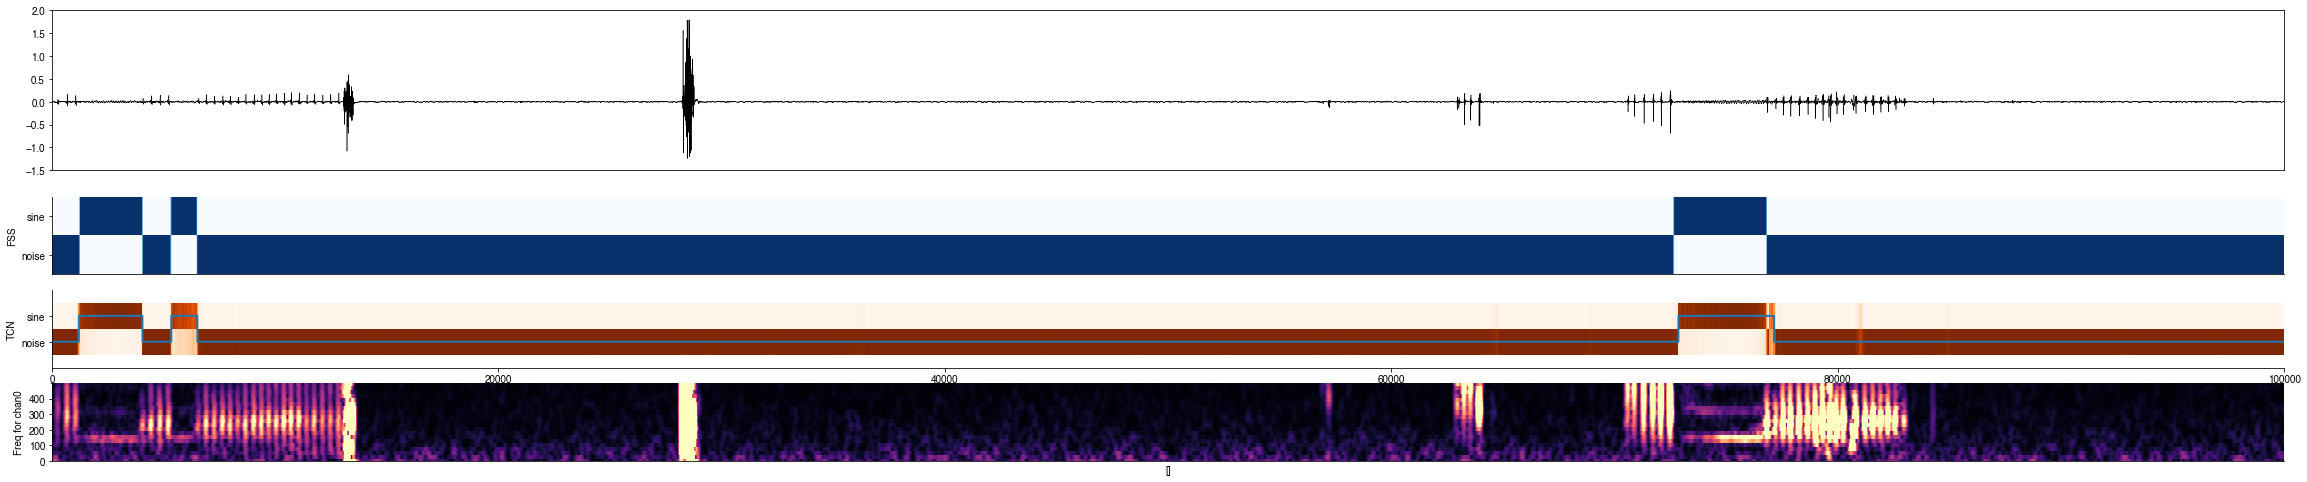

In [11]:
import librosa.feature
import librosa.display

t0 = 0
t1 = t0 + 100_000

nb_channels = x_test.shape[1]
x_snippet = x_test[y_offset + t0*dwn_smp:y_offset+t1*dwn_smp,:]
plt.gcf().set_size_inches(40, 10)

plt.subplot((nb_channels+5)/2, 1, 1)
plt.plot(x_snippet + np.arange(nb_channels)/10, c='k', linewidth=0.5)
plt.xticks([])

plt.subplot(nb_channels+5,1, 3)
plt.imshow(y_test[t0:t1].T, cmap='Blues')
plt.yticks((0, 1), labels=params['class_names'])
plt.ylabel('FSS')
plt.xticks([])
dss.utils_plot.remove_axes()

plt.subplot(nb_channels+5,1, 4)
plt.imshow(y_pred[t0:t1].T, cmap='Oranges')
# plt.plot(labels_pred[t0:t1], 'k', linewidth=2)
plt.plot(labels_pred3[t0:t1], linewidth=2)
plt.yticks((0, 1), labels=params['class_names'])
plt.ylabel('TCN')
plt.xlim(0, t1 - t0)
dss.utils_plot.remove_axes()

for cnt, x in enumerate(x_snippet.T):
    specgram = librosa.feature.melspectrogram(x, sr=10000, n_fft=512, hop_length=1, power=1)
    plt.subplot(nb_channels+5,1, 5+cnt)
    librosa.display.specshow(np.log2(1 + specgram), sr=10_000, hop_length=1, y_axis='mel', x_axis='ms')
    plt.clim(0, 0.2)
    plt.ylim(0, 500)
    dss.utils_plot.remove_axes()
    if cnt<8:
        plt.xticks([])
        plt.xlabel([])
    plt.yticks(np.arange(0, 500, 100))    
    plt.ylabel(f'Freq for chan{cnt}')

### 